This lab on Splines and GAMs is a python adaptation of p. 293-297 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. It was originally written by <a href = "https://github.com/JWarmenhoven">Jordi Warmenhoven</a>, and was adapted by R. Jordan Crouser at Smith College in Spring 2016. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
# Read in the data
df = pd.read_csv('https://raw.githubusercontent.com/kirenz/datasets/master/wage.csv')

# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# 7.8.2 Splines

In order to fit regression splines in python, we use the ${\tt dmatrix}$ module from the ${\tt patsy}$ library. In lecture, we saw that regression splines can be fit by constructing an appropriate matrix of basis functions. The ${\tt bs()}$ function generates the entire matrix of basis functions for splines with the specified set of knots.  Fitting ${\tt wage}$ to ${\tt age}$ using a regression spline is simple:

In [3]:
from patsy import dmatrix

# Specifying 3 knots
transformed_x1 = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')

# Build a regular linear model from the splines
fit1 = sm.GLM(df.wage, transformed_x1).fit()
fit1.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

Here we have prespecified knots at ages 25, 40, and 60. This produces a
spline with six basis functions. (Recall that a cubic spline with three knots
has seven degrees of freedom; these degrees of freedom are used up by an
intercept, plus six basis functions.) We could also use the ${\tt df}$ option to
produce a spline with knots at uniform quantiles of the data:

In [4]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit2 = sm.GLM(df.wage, transformed_x2).fit()
fit2.params

Intercept                                       56.313841
bs(df.age, df=6, include_intercept=False)[0]    27.824002
bs(df.age, df=6, include_intercept=False)[1]    54.062546
bs(df.age, df=6, include_intercept=False)[2]    65.828391
bs(df.age, df=6, include_intercept=False)[3]    55.812734
bs(df.age, df=6, include_intercept=False)[4]    72.131473
bs(df.age, df=6, include_intercept=False)[5]    14.750876
dtype: float64

In this case python chooses knots which correspond
to the 25th, 50th, and 75th percentiles of ${\tt age}$. The function ${\tt bs()}$ also has
a ${\tt degree}$ argument, so we can fit splines of any degree, rather than the
default degree of 3 (which yields a cubic spline).

In order to instead fit a natural spline, we use the ${\tt cr()}$ function. Here
we fit a natural spline with four degrees of freedom:

In [5]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit3 = sm.GLM(df.wage, transformed_x3).fit()
fit3.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

As with the ${\tt bs()}$ function, we could instead specify the knots directly using
the ${\tt knots}$ option.

Let's see how these three models stack up:

Text(0, 0.5, 'wage')

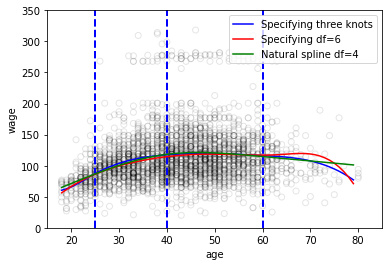

In [6]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Make some predictions
pred1 = fit1.predict(dmatrix("bs(age_grid, knots=(25,40,60), include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(age_grid, df=6, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
pred3 = fit3.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))

# Plot the splines and error bands
plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(age_grid, pred1, color='b', label='Specifying three knots')
plt.plot(age_grid, pred2, color='r', label='Specifying df=6')
plt.plot(age_grid, pred3, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')